In [5]:
import ast
import json
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns

from collections import defaultdict
from os.path import join

import sys
sys.path.append("..")

from seal.trainer.communication import *

In [2]:
sample_path = join("..", "out", "data", "FedRL", "grid-3x3", "dummy_ranked.csv")
sample_df = pd.read_csv(sample_path)
print(sample_df.columns)
sample_df["hist_stats"][0]

Index(['Unnamed: 0', 'round', 'trainer', 'policy', 'fed_round',
       'policy_reward', 'num_vehicles', 'episode_reward_max',
       'episode_reward_min', 'episode_reward_mean', 'episode_len_mean',
       'episode_media', 'episodes_this_iter', 'policy_reward_min',
       'policy_reward_max', 'policy_reward_mean', 'custom_metrics',
       'hist_stats', 'sampler_perf', 'off_policy_estimator',
       'num_healthy_workers', 'timesteps_total', 'agent_timesteps_total',
       'timers', 'info', 'done', 'episodes_total', 'training_iteration',
       'experiment_id', 'date', 'timestamp', 'time_this_iter_s',
       'time_total_s', 'pid', 'hostname', 'node_ip', 'config',
       'time_since_restore', 'timesteps_since_restore',
       'iterations_since_restore', 'perf', 'callback_ok'],
      dtype='object')


"{'policy_B0_comm=edge-to-tls-policy-comms': [0], 'policy_B0_comm=tls-to-edge-policy-comms': [0], 'policy_B0_comm=edge-to-tls-action-comms': [0], 'policy_B0_comm=edge-to-tls-rank-comms': [240], 'policy_B0_comm=tls-to-edge-obs-comms': [0], 'policy_B0_comm=veh-to-tls-info-comms': [3752], 'policy_C1_comm=edge-to-tls-policy-comms': [0], 'policy_C1_comm=tls-to-edge-policy-comms': [0], 'policy_C1_comm=edge-to-tls-action-comms': [0], 'policy_C1_comm=edge-to-tls-rank-comms': [240], 'policy_C1_comm=tls-to-edge-obs-comms': [0], 'policy_C1_comm=veh-to-tls-info-comms': [3252], 'policy_A0_comm=edge-to-tls-policy-comms': [0], 'policy_A0_comm=tls-to-edge-policy-comms': [0], 'policy_A0_comm=edge-to-tls-action-comms': [0], 'policy_A0_comm=edge-to-tls-rank-comms': [240], 'policy_A0_comm=tls-to-edge-obs-comms': [0], 'policy_A0_comm=veh-to-tls-info-comms': [832], 'policy_A1_comm=edge-to-tls-policy-comms': [0], 'policy_A1_comm=tls-to-edge-policy-comms': [0], 'policy_A1_comm=edge-to-tls-action-comms': [0], 

In [11]:
def preprocess_data(path) -> pd.DataFrame:
    raw_df = pd.read_csv(path)
    preprocess = defaultdict(list)
    for i in range(len(raw_df)):
        for comm_type in COMM_TYPES:
            policy = raw_df["policy"][i]
            preprocess["round"].append(raw_df["round"][i])
            preprocess["trainer"].append(raw_df["trainer"][i])
            preprocess["policy"].append(policy)
            preprocess["timesteps_total"].append(raw_df["timesteps_total"][i])
            preprocess["policy_reward"].append(raw_df["policy_reward"][i])
            # preprocess["episode_reward"].append(raw_df["episode_reward"][i])
            query = f"policy_{policy}_comm={comm_type}"
            hist_stats = ast.literal_eval(raw_df["hist_stats"][i])
            found = False
            for key in hist_stats:
                if found:
                    continue
                if query == key:
                    comm_cost = hist_stats[query][-1]
                    preprocess["comm_cost"].append(comm_cost)
                    preprocess["comm_type"].append(comm_type)
                    found = True
            if not found:
                    preprocess["comm_cost"].append(None)
                    preprocess["comm_type"].append(None)
    return pd.DataFrame.from_dict(preprocess)

In [12]:
df = preprocess_data(sample_path)
df.head()

,round,trainer,policy,timesteps_total,policy_reward,comm_cost,comm_type
0,0,FedRL,A0,240,-0.386525,0.0,tls-to-edge-obs-comms
1,0,FedRL,A0,240,-0.386525,240.0,edge-to-tls-rank-comms
2,0,FedRL,A0,240,-0.386525,0.0,edge-to-tls-action-comms
3,0,FedRL,A0,240,-0.386525,0.0,edge-to-tls-policy-comms
4,0,FedRL,A0,240,-0.386525,832.0,veh-to-tls-info-comms


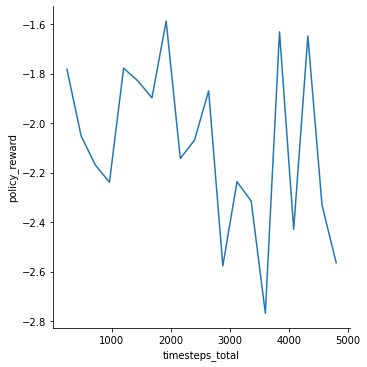

In [17]:
sns.relplot(data=df, kind="line", x="timesteps_total", y="policy_reward")
plt.show()

/usr/local/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


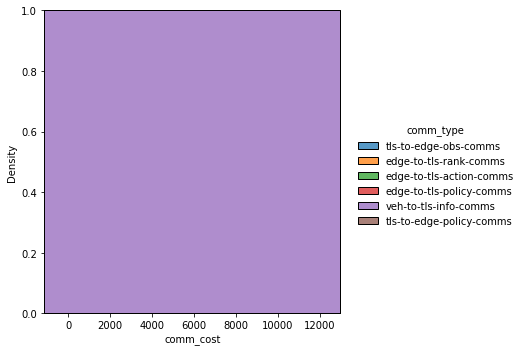

In [21]:
sns.displot(data=df, kind="kde", x="comm_cost", hue="comm_type", multiple="fill", facet_kws={"sharey": False, "sharex": False})#.set(xscale="log")
plt.show()